In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
try:
    import cupy as cp
    print("CuPy успешно загружен. Используется GPU ускорение.")
    USE_GPU = True
    print(f"GPU устройство: {cp.cuda.Device().compute_capability}")
    print(f"Память GPU: {cp.cuda.Device().mem_info[1] / 1024**3:.2f} GB")
except ImportError:
    print("CuPy не установлен. Используется CPU (NumPy).")
    import numpy as cp
    USE_GPU = False

from dllib.utils import device
from dllib.model import Transformer

device.configure_backend(cp, USE_GPU)
device.seed_everything(121)
xp = device.xp

CuPy успешно загружен. Используется GPU ускорение.
GPU устройство: 86
Память GPU: 24.00 GB


In [2]:
csv_file = "toxic_comments.csv"
df = pd.read_csv(csv_file)
print(df.columns)

Index(['comment', 'toxic', 'translated'], dtype='object')


In [3]:
texts = df["comment"].astype(str).tolist()
labels = df["toxic"].astype(int).values

tokenized = [t.split() for t in texts]

vocab = {}
for sentence in tokenized:
    for word in sentence:
        if word not in vocab:
            vocab[word] = len(vocab) + 1

vocab_size = len(vocab) + 1

max_len = 80
X = np.zeros((len(tokenized), max_len), dtype=int)
for i, sentence in enumerate(tokenized):
    for j, word in enumerate(sentence[:max_len]):
        X[i, j] = vocab.get(word, 0)

y = labels

indices = np.arange(len(y))  # индексы исходного датасета

x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)
x_train = xp.asarray(x_train)
y_train = xp.asarray(y_train)
x_test  = xp.asarray(x_test)
y_test  = xp.asarray(y_test)

In [4]:
model = Transformer(
    vocab_size=vocab_size,
    d_model=max_len,
    num_heads=2,
    ff_hidden_dim=64,
    num_classes=2,
    num_layers=3,
    dropout=0.4,
)

In [5]:
history = model.train(
    x_train, y_train,
    x_test=x_test, y_test=y_test,
    batch_size=32,
    epochs=15,
    verbose=True
)

Epoch 1/15 | Train Loss: 0.72990, Train Acc: 0.55599 | Test Loss: 0.70122, Test Acc: 0.67430
Epoch 2/15 | Train Loss: 0.67823, Train Acc: 0.61835 | Test Loss: 0.64817, Test Acc: 0.67395
Epoch 3/15 | Train Loss: 0.65376, Train Acc: 0.64221 | Test Loss: 0.62199, Test Acc: 0.67395
Epoch 4/15 | Train Loss: 0.63511, Train Acc: 0.65357 | Test Loss: 0.60637, Test Acc: 0.67430
Epoch 5/15 | Train Loss: 0.63289, Train Acc: 0.64680 | Test Loss: 0.59816, Test Acc: 0.67430
Epoch 6/15 | Train Loss: 0.61927, Train Acc: 0.65661 | Test Loss: 0.59628, Test Acc: 0.67430
Epoch 7/15 | Train Loss: 0.60979, Train Acc: 0.66207 | Test Loss: 0.58960, Test Acc: 0.67430
Epoch 8/15 | Train Loss: 0.60345, Train Acc: 0.66840 | Test Loss: 0.58234, Test Acc: 0.68991
Epoch 9/15 | Train Loss: 0.59522, Train Acc: 0.67204 | Test Loss: 0.57821, Test Acc: 0.69476
Epoch 10/15 | Train Loss: 0.58686, Train Acc: 0.67933 | Test Loss: 0.58118, Test Acc: 0.67430
Epoch 11/15 | Train Loss: 0.57990, Train Acc: 0.68002 | Test Loss: 0.

In [6]:
y_proba = model.predict_proba(x_test)   # shape: (N, 2)
y_pred = model.predict(x_test)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(
    y_test.get() if hasattr(y_test, "get") else y_test,
    y_pred.get() if hasattr(y_pred, "get") else y_pred,
    target_names=["non-toxic", "toxic"]
))

              precision    recall  f1-score   support

   non-toxic       0.77      0.92      0.84      1944
       toxic       0.73      0.42      0.53       939

    accuracy                           0.76      2883
   macro avg       0.75      0.67      0.69      2883
weighted avg       0.75      0.76      0.74      2883



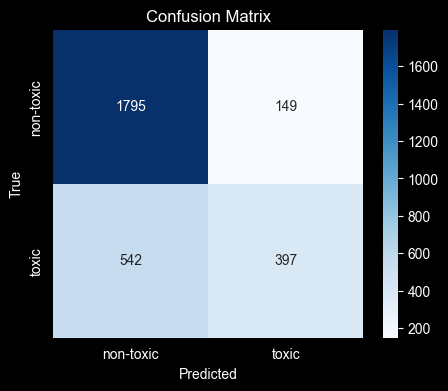

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(
    y_test.get() if hasattr(y_test, "get") else y_test,
    y_pred.get() if hasattr(y_pred, "get") else y_pred
)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non-toxic", "toxic"],
            yticklabels=["non-toxic", "toxic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

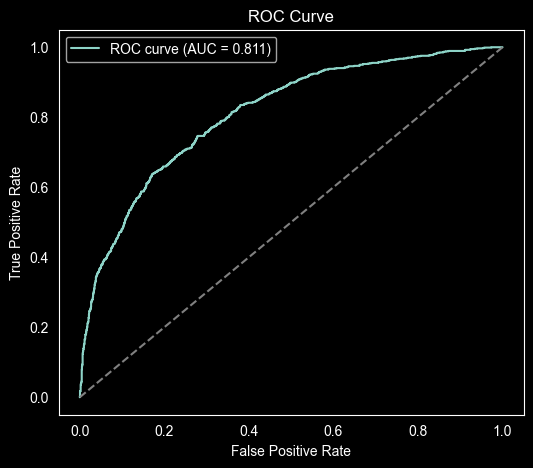

In [9]:
from sklearn.metrics import roc_curve, auc

# вероятность токсичности
y_score = y_proba[:, 1]

fpr, tpr, _ = roc_curve(
    y_test.get() if hasattr(y_test, "get") else y_test,
    y_score.get() if hasattr(y_score, "get") else y_score
)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Модель угадала

In [10]:
y_test_cpu = y_test.get() if hasattr(y_test, "get") else y_test
y_pred_cpu = y_pred.get() if hasattr(y_pred, "get") else y_pred

In [11]:
correct_idxs = np.where(y_test_cpu == y_pred_cpu)[0]
correct_toxic = [i for i in correct_idxs if y_test_cpu[i] == 1]
correct_non_toxic = [i for i in correct_idxs if y_test_cpu[i] == 0]
random_toxic = np.random.choice(correct_toxic, size=3, replace=False)
random_non_toxic = np.random.choice(correct_non_toxic, size=3, replace=False)
final_idxs = np.concatenate([random_toxic, random_non_toxic])
np.random.shuffle(final_idxs)
for i in final_idxs:
    orig_idx = idx_test[i]  # индекс строки в исходном df
    cls = 'Toxic' if y_test_cpu[i] else 'Non-toxic'
    print(f'CLASS: {cls}')
    print(f'TEXT: {texts[orig_idx]}\n')

CLASS: Non-toxic
TEXT: У этих людей работа такая. Ну и средств получения информации гораздо больше чем у рядового, да даже не рядового, следователя. Однако они и мелочью не занимаются, решают проблемы других порядков.


CLASS: Non-toxic
TEXT: В свое время всем подряд предлагали берцы от Восток Сервис и они на самом деле были всем хороши, вот только скользили ужасно. 100 правда. Осенью купил их зимники. Удобные, в меру теплые, но для зашей зимы непригодны, первые минут 5 после выхода на снег - ебаный каток. Потом, видимо, подошва подмерзает и становится получше, но не отлично


CLASS: Toxic
TEXT: Ебать тут весь тред о Новороссия. Боты, вы ебанутые? Какие Загитовы, деревенские долбоебы, котеночки, блядь. Как Новороссия до этого скатилась?


CLASS: Toxic
TEXT: Да куда тебе ехать, пойдём у меня посидим вина попьём, потом поедешь


CLASS: Toxic
TEXT: Русачки ебаные, какого хуя вы отдали Польше мою Белостокскую область, половину Беловежской Пущи и мою столицу Вильню жемайтам? А, пидарасы? Ка

In [12]:
incorrect_idxs = np.where(y_test_cpu != y_pred_cpu)[0]
false_positive = [i for i in incorrect_idxs if y_test_cpu[i] == 0 and y_pred_cpu[i] == 1]
false_negative = [i for i in incorrect_idxs if y_test_cpu[i] == 1 and y_pred_cpu[i] == 0]
n_fp = min(3, len(false_positive))
n_fn = min(3, len(false_negative))
random_fp = np.random.choice(false_positive, size=n_fp, replace=False)
random_fn = np.random.choice(false_negative, size=n_fn, replace=False)
final_incorrect = np.concatenate([random_fp, random_fn])
np.random.shuffle(final_incorrect)
for i in final_incorrect:
    orig_idx = idx_test[i]
    true_cls = 'Toxic' if y_test_cpu[i] == 1 else 'Non-toxic'
    pred_cls = 'Toxic' if y_pred_cpu[i] == 1 else 'Non-toxic'
    print(f'TRUE: {true_cls} | PRED: {pred_cls}')
    print(f'TEXT: {texts[orig_idx]}\n')

TRUE: Toxic | PRED: Non-toxic
TEXT: Поэтому просто стеснялись выгонять, чтобы не прослыть женоненавистниками и задротами Ну и бред. Настоящие чуваки свободные от баборабства так не поступают.


TRUE: Toxic | PRED: Non-toxic
TEXT: Анон, моя Родина - Татарстан - смертельно больна. Ее поразили метастазы русизма, охватившие буквально все в моей Республике. Опухоль настолько разрослась, что проникла даже в наше некогда сплоченное и приверженное национальным ценностям правительство - теперь и там вы увидите кучу русколобых на руководящих должностях.

TRUE: Non-toxic | PRED: Toxic
TEXT: Досмотрел до туда, теперь думаю, что это успешный выращиватель травы объебался и сделался добрым.


TRUE: Non-toxic | PRED: Toxic
TEXT: Ты очень общительный человек?


TRUE: Toxic | PRED: Non-toxic
TEXT: Удивительно: этого дегенерата всё ещё смотрят. Как вам там под парашей, опущенцы? Нормас?


TRUE: Non-toxic | PRED: Toxic
TEXT: Да студенческая команда из штатов вынесет любую российскую вперед ногами

